In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%cd ..

/home/proste/mff/evgena


In [3]:
from evgena.ga.core import *
from evgena.models import Model, KerasModel
from evgena.ga.callbacks import GAStatus, BestImgReport, HistoryReport
from evgena.ga.operators import TwoPointXover, BiasedMutation, TournamentSelection
from evgena.ga.initializers import RandomStdInit
from evgena.dataset import loader

Using TensorFlow backend.
/home/proste/mff/evgena/env_evgena/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [4]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from skimage.measure import compare_ssim as ssim

In [5]:
from IPython.core.debugger import set_trace

# TODO
- initializer - random noise
- xover - 2D 2 point
- mutation - gaussian? simulated annealing?
- objective - softmax value of desired output - maximizing, noise abs sum - minimizing
- selection tournament?
- normalize images to floats (retrain model, change code)
- ...

In [6]:
class ShuffleOperator(OperatorBase):
    def __init__(self, input_op: OperatorBase):
        super(ShuffleOperator, self).__init__(input_op)
        
    def _operation(self, ga: GeneticAlgorithm, *input_populations: Population):
        input_pop = input_populations[0]
        
        output_individuals = np.random.permutation(input_pop.individuals)
        
        return Population(output_individuals, ga)

In [7]:
class NSGAOperator(OperatorBase):
    def __init__(self, parents_op: OperatorBase, offspring_op: OperatorBase):
        super(NSGAOperator, self).__init__(parents_op, offspring_op)
        
    def _operation(self, ga: GeneticAlgorithm, *input_populations: Population):
        parents = input_populations[0]
        offspring = input_populations[1]
        
        # merge parents with offspring
        individuals = np.concatenate((parents.individuals, offspring.individuals))
        fitnesses = np.concatenate((parents.fitnesses, offspring.fitnesses))
        pool_size = len(individuals)
        pop_size = parents.size
        
        fitnesses_count = fitnesses.shape[1]
        fitnesses_rank_to_index = np.argsort(fitnesses, axis=0)
        fitnesses_index_to_rank = np.argsort(fitnesses_rank_to_index, axis=0)

        # find dominating and dominated
        subs_indices = [None] * (pool_size)  # indices of individuals one is dominating
        doms_count = np.empty(shape=pool_size, dtype=np.int)  # number of individuals one is dominated by

        for i_i in range(pool_size):
            # iteratively build dominating and dominated
            i_rank = fitnesses_index_to_rank[i_i, 0]
            subs = fitnesses_rank_to_index[:i_rank, 0]
            doms = fitnesses_rank_to_index[i_rank + 1:, 0]
            for f_i in range(1, fitnesses_count):
                i_rank = fitnesses_index_to_rank[i_i, f_i]
                subs = np.intersect1d(subs, fitnesses_rank_to_index[:i_rank, f_i], assume_unique=True)
                doms = np.intersect1d(doms, fitnesses_rank_to_index[i_rank + 1:, f_i], assume_unique=True)

            # assign dominating and dominated
            subs_indices[i_i] = subs
            doms_count[i_i] = len(doms)

        # build non-dominated fronts
        fronts = []  # list of fronts (indices of individuals per front)
        choice_size = 0  # number of individuals chosen so far
        while True:
            # fetch non-dominated solutions
            front_indices, *_ = np.where(doms_count == 0)

            # keep front indices and update count of individuals chosen so far
            fronts.append(front_indices)
            choice_size += len(front_indices)


            if choice_size >= pop_size:
                break

            # invalidate individuals for future loop executions
            doms_count[front_indices] = -1

            # remove current front
            for i_i in range(len(front_indices)):
                doms_count[subs_indices[front_indices[i_i]]] -= 1

        # secondary sorting
        if choice_size > pop_size:
            # crowding-distance
            last_front = fronts[-1]

            normalised_distances = np.empty((len(last_front), fitnesses_count))
            for f_i in range(fitnesses_count):
                front_rank_to_index = np.argsort(fitnesses_index_to_rank[last_front, f_i])
                sorted_front = last_front[front_rank_to_index]

                dim_distances = fitnesses[sorted_front[2:], f_i] - fitnesses[sorted_front[:-2], f_i]
                dim_range = fitnesses[sorted_front[-1], f_i] - fitnesses[sorted_front[0], f_i]
                normalised_distances[front_rank_to_index[1:-1], f_i] = dim_distances / dim_range
                normalised_distances[front_rank_to_index[[0, -1]], f_i] = np.inf

            averaged_distances = np.average(normalised_distances, axis=1)

            choice = np.concatenate(fronts[:-1] + [last_front[np.argsort(averaged_distances)[(choice_size - pop_size):]]])
        else:
            choice = np.concatenate(fronts)

        return Population(individuals[choice], ga)

In [8]:
# TODO tf model objective function combined with distance (table)
class PyGAAObjectiveFnc(ObjectiveFncBase):
    def __init__(self, model: Model, target_label: int, source_image: np.ndarray):
        super(PyGAAObjectiveFnc, self).__init__()
        
        self._model = model
        self._target_label = target_label
        self._source_image = source_image
        
    def __call__(self, individuals: np.ndarray) -> np.ndarray:        
        # norm of flattened individual - source_image
        norms = np.empty(len(individuals), np.float)
        for i in range(len(individuals)):
            norms[i] = ssim(self._source_image.astype(np.float), individuals[i])
        
#         norms = np.linalg.norm((individuals - self._source_image).reshape((len(individuals), -1)), axis=-1)
                               
        # logits on individuals values in [0, 1]
        logits = model(np.expand_dims(individuals, -1))[:, self._target_label]
        
        # create array by merging columns
        return np.stack((logits, norms), axis=-1)

In [9]:
class PyGAAFitnessFnc(FitnessFncBase):
    def __call__(self, individuals: np.ndarray, objectives: np.ndarray) -> np.ndarray:
        return objectives

In [29]:
graph = OperatorGraph()

select_op = ShuffleOperator(graph.init_op)
xover_op = TwoPointXover(select_op, 0.6)
mutation_op = BiasedMutation(xover_op, sigma=16, l_bound=0, u_bound=255)
moea_op = NSGAOperator(graph.init_op, mutation_op)

# select_op = TournamentSelection(graph.init_op, 3)
# xover_op = TwoPointXover(select_op, 0.6)
# mutation_op = BiasedMutation(xover_op, sigma=5, l_bound=0, u_bound=255)

In [11]:
model = KerasModel('playground/best_residual_dropout_nn_emnist_2.h5', 512)

In [12]:
(train_X, train_y), (test_X, test_y), index = loader.load_idx_dataset('datasets/emnist_balanced/')

In [ ]:
plt.imshow(train_X[15])

In [13]:
class MultiObjectiveReport(CallbackBase):
    def __init__(self, ax: plt.Axes):
        super(MultiObjectiveReport, self).__init__()
        
        self._ax = ax

    def __call__(self, ga: 'GeneticAlgorithm') -> None:
        self._ax.lines = []
        self._ax.plot(*ga.capture(-1).objectives.transpose(), 'r+')

<IPython.core.display.Javascript object>


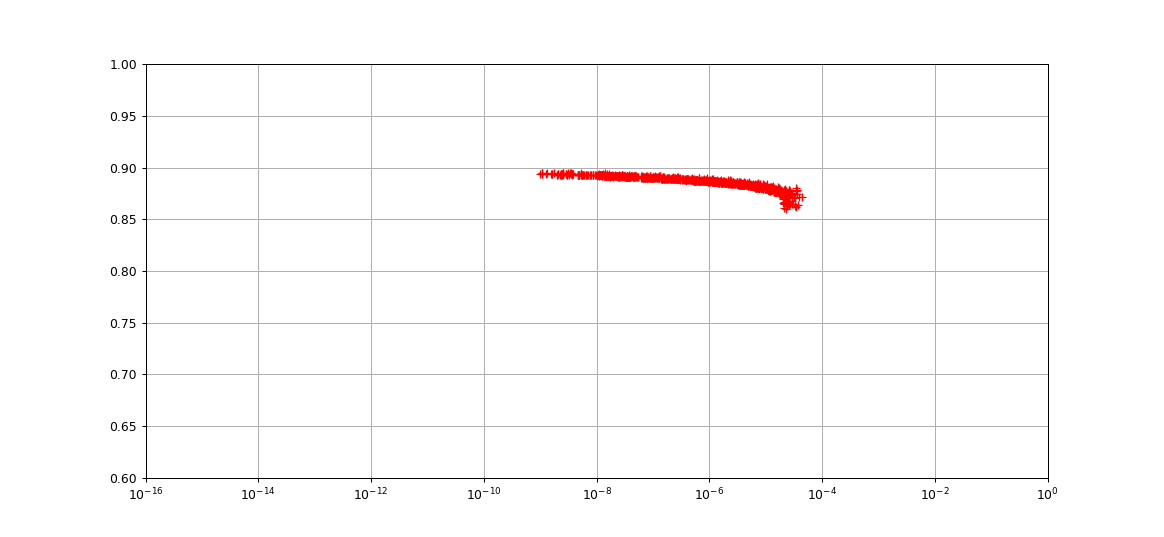

In [131]:
%matplotlib notebook

fig, ax = plt.subplots(1, 1, figsize=(13,6))
# fig.tight_layout()

ax.set_xlim(0.0000000000000001, 1)
ax.set_ylim(0.6, 1)
ax.set_xscale('log')
ax.grid(axis='both')

callbacks = [GAStatus(fig), MultiObjectiveReport(ax)]
# callbacks = [GAStatus(fig), BestImgReport(ax[0, 0]), HistoryReport(ax[0, 1], ax[1, 0], ax[1, 1])]

In [133]:
ga = GeneticAlgorithm(
    initialization=RandomStdInit((28, 28), sigma=32, mu=train_X[15]),
    operator_graph=graph,
    objective_fnc=PyGAAObjectiveFnc(model, 32, train_X[15]),
    fitness_fnc=PyGAAFitnessFnc(),
    callbacks=callbacks
)

In [ ]:
final_pop, fitnesses, objectives = ga.run(population_size=1024, generation_cap=512)

In [135]:
result = _

In [136]:
pop, fitnesses, objectives = result

ValueError: not enough values to unpack (expected 3, got 0)

In [88]:
best_i = fitnesses[-1, :, 0].argmax()

In [89]:
feasible_indices, *_ = np.where(fitnesses[-1, :, 0] > 0.5)

In [93]:
best_i = feasible_indices[fitnesses[-1, feasible_indices, 1].argmax()]

In [95]:
best_i

array([ 0.50082707,  0.92484596])

<IPython.core.display.Javascript object>


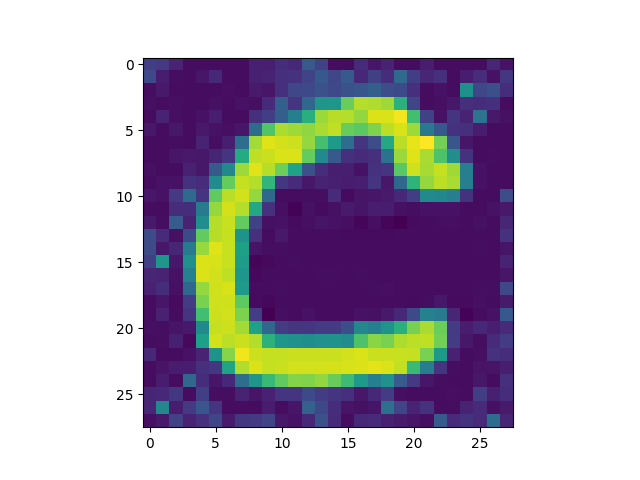

In [103]:
%matplotlib notebook

compare_fig, compare_ax = plt.subplots(1, 2, figsize=(13, 6))
compare_ax[0].imshow(train_X[15])
compare_ax[1].imshow(pop.individuals[best_i] - train_X[15])

In [119]:
# pred = model((pop.individuals[best_i] - train_X[15] + train_X[116]).reshape(1,28,28,1))
pred = model((train_X[15]).reshape(1,28,28,1))

In [120]:
pred.argmax()

12

In [121]:
index[pred.argmax()]

['C']

In [ ]:
%matplotlib notebook

plt.imshow(result_pop.individuals[result_pop.fitnesses.argmax()])

In [ ]:
result.fitnesses.argmax()

In [ ]:
result.individuals[1]

In [ ]:
index[model(train_X[15].reshape((1,28,28,1))).argmax()]

In [ ]:
winner = result_pop.individuals[result_pop.fitnesses.argmax()]

In [ ]:
index[model(winner.reshape((1,28,28,1))).argmax()]

In [ ]:
%matplotlib notebook

BestImgReport()

In [ ]:
# TODO composite layout - callbacks register their respective output window (or the window is assigned - axis object)